In [175]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg' # For mac users with Retina display

import numpy as np
import matplotlib.pyplot as plt
import sys, random
sys.path.append('/Users/fbianchini/Research/FlatSpec/')
from Spec2D import *
from Sims import *
from cosmojo.universe import Cosmo
from cosmojo.utils import nl_cmb, bl
from scipy.integrate import simps
from astropy.io import fits
import scipy.signal

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [176]:
# Generate theoretical CMB power spectrum and noise

noise_muK_arcmin = 20.
beam = 1.

cltt = Cosmo(lmax=8000).cmb_spectra(8000, dl=False)[:,0]
nltt = nl_cmb(noise_muK_arcmin, 0., lmax=10000) # 20 \muK, no beam because I smooth later
nltt_1f = nl_cmb(noise_muK_arcmin, 0., lmax=10000, lknee=300, alpha=2.)


In [177]:
arcmin2rad = np.pi / 180. / 60. 


def GetCutout(pixmap, pixcent, npix):
    """
    Extracts a cutout of size (npix,npix) centered in (pixcent[0], pixcent[1]) from a bigger map pixmap
    """
    x, y = pixcent
    x, y = np.int(x), np.int(y)
    return pixmap[y-npix:y+npix+1, x-npix:x+npix+1]

def GoGetStack(x, y, skymap, mask, npix):
    results = {}
    results['maps'] = []
    
    for i in xrange(len(x)):
        cutmask = GetCutout(mask, (x[i],y[i]), npix=npix)
#         print cutmask.shape
        isgood = True if (np.mean(cutmask) == 1) & (cutmask.shape == (2*npix+1,2*npix+1)) else False # Do analysis if all the cutout within the footprint

#         print x[i], y[i], isgood, np.mean(cutmask)

        if isgood: # Cutout is *completely* in the footprint
            results['maps'].append(GetCutout(skymap, (x[i],y[i]), npix=npix))
        else: # discard object
            pass

    results['maps'] = np.asarray(results['maps'])			
    
    return results

def twoD_Gaussian((x, y), amplitude, xo, yo, sigma_x=1, sigma_y=1, theta=0., offset=0):
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))
    return g#.ravel()

def Add2dGauss(x, y, data, npix, amp=5.):
    for i in xrange(len(x)):
        X, Y = np.meshgrid(np.arange(y[i]-npix, y[i]+npix+1), np.arange(x[i]-npix, x[i]+npix+1))
#         X -= x[i]
#         Y -= y[i]
#         plt.imshow(twoD_Gaussian((X,Y), amplitude=amp, xo=x[i], yo=y[i]))
        try:
            data[y[i]-npix:y[i]+npix+1, x[i]-npix:x[i]+npix+1] += twoD_Gaussian((Y,X), amplitude=amp, xo=x[i], yo=y[i], sigma_x=1, sigma_y=1)
#             plt.imshow(twoD_Gaussian((Y,X), amplitude=amp, xo=x[i], yo=y[i], sigma_x=1, sigma_y=1))
        except:
#             print sys.exc_info()
            pass
    return data

def FilterMap(pixmap, lmin, lmax, reso, pad=1):
    if pad !=1:
        pixmap = np.pad(pixmap, ((pixmap.shape[0], pixmap.shape[0])), mode='constant', constant_values=0.)
    
    ft = np.fft.fftshift(np.fft.fft2(pixmap))
    mask = GetLMask(pixmap.shape[0], dx=reso, lmin=lmin, lmax=lmax, shift=True)
    
    return np.fft.ifft2(np.fft.fftshift(ft*mask)).real
    
def GetLMask(nx, dx, ny=None, dy=None, shift=False, lmin=None, lmax=None, lxmin=None, lxmax=None, lymin=None, lymax=None):
    """ 
    return a Fourier mask for the pixelization associated with this object which is zero over customizable ranges of L. 
    """
    if ny == None: ny = nx
    mask      = np.ones((ny, nx), dtype=np.complex)
    lx, ly    = GetLxLy(nx, dx, ny=ny, dy=dy, shift=shift)
    L         = GetL(nx, dx, dy=dy, ny=ny, shift=shift)
    if lmin  != None: mask[ np.where(L < lmin) ] = 0.0
    if lmax  != None: mask[ np.where(L >=lmax) ] = 0.0
    if lxmin != None: mask[ np.where(np.abs(lx) < lxmin) ] = 0.0
    if lymin != None: mask[ np.where(np.abs(ly) < lymin) ] = 0.0
    if lxmax != None: mask[ np.where(np.abs(lx) >=lxmax) ] = 0.0
    if lymax != None: mask[ np.where(np.abs(ly) >=lymax) ] = 0.0

    return mask

def GetLxLy(nx, dx, ny=None, dy=None, shift=True):
    """ 
    Returns two grids with the (lx, ly) pair associated with each Fourier mode in the map. 
    If shift=True (default), \ell = 0 is centered in the grid
    ~ Note: already multiplied by 2\pi 
    """
    if ny is None: ny = nx
    if dy is None: dy = dx
    
    dx *= arcmin2rad
    dy *= arcmin2rad
    
    if shift:
        return np.meshgrid( np.fft.fftshift(np.fft.fftfreq(nx, dx))*2.*np.pi, np.fft.fftshift(np.fft.fftfreq(ny, dy))*2.*np.pi )
    else:
        return np.meshgrid( np.fft.fftfreq(nx, dx)*2.*np.pi, np.fft.fftfreq(ny, dy)*2.*np.pi )


def GetL(nx, dx, ny=None, dy=None, shift=True):
    """ 
    Returns a grid with the wavenumber l = \sqrt(lx**2 + ly**2) for each Fourier mode in the map. 
    If shift=True (default), \ell = 0 is centered in the grid
    """
    lx, ly = GetLxLy(nx, dx, ny=ny, dy=dy, shift=shift)
    return np.sqrt(lx**2 + ly**2)

def GetACTbeam(nx, dx, dy=None, ny=None, shift=True, filepath='/Users/fbianchini/Documents/beams_AR2_2010_season_130224.dat.txt'):
    """ 
    Returns 2D FT of ACT beam.
    If shift=True (default), \ell = 0 is centered in the grid
    """
    if ny is None: ny = nx
    if dy is None: dy = dx
 
    l, bl = np.loadtxt(filepath, unpack=True)
    L = GetL(nx, dx, ny=ny, dy=dy, shift=shift)
    idx = np.where(L > 20000)
    xx = np.interp(L, l, bl)
    xx[idx] = 0.
#     plt.semilogy(l,bl)
    return xx

def Get2dSpectra(pixmap, dx, dy=None, shift=True):
    ny, nx = pixmap.shape
    
    if dy is None: dy = dx
    
    dx *= arcmin2rad
    dy *= arcmin2rad

    if shift:
        ft = np.fft.fftshift(np.fft.fft2(pixmap))
    else:
        ft = np.fft.fft2(pixmap)
    return (np.abs(ft)) #* (dx*dy)/(nx*ny)

def MatchFilter(pixmap, dx, dy=None, beam=0., lmin=None, lmax=None, lxmin=None, lxmax=None, lymin=None, lymax=None, shift=True):
    ny, nx = pixmap.shape

    # Anisotropic filter
    F = GetLMask(nx, dx, dy=dy, ny=ny, shift=shift, lmin=lmin, lmax=lmax, lxmin=lxmin, lxmax=lxmax, lymin=lymin, lymax=lymax)
    
#     plt.matshow(np.abs(F))
    
    # Beam
    if beam == 0.:
        B = np.ones_like(F)
    elif beam > 0.:
        B = make_2d_gaussian_beam(nx, dx, beam, shift=shift)
        
    T = Get2dSpectra(pixmap, dx, dy=dy, shift=shift)
    T2_inv = np.nan_to_num(1./np.abs(T))**2
    BFTB = np.conj(B) * F * T2_inv * B #reduce(np.dot, [np.conj(B), F, T2_inv, B])
    integral = simps(simps(BFTB, x=GetLxLy(nx, dx, dy=dy, ny=ny)[1][:,0]), x=GetLxLy(nx, dx, dy=dy, ny=ny)[0][0,:])

    return np.nan_to_num(F * np.conj(B) * T2_inv) / integral#reduce(np.dot, [F, B, T2_inv]) / integral 

def MatchFilterMap(pixmap, dx, dy=None, ny=None, beam=0., lmin=None, lmax=None, lxmin=None, lxmax=None, lymin=None, lymax=None, shift=False, pad=1):
    ny, nx = pixmap.shape
    
#     mask = smooth_window(np.ones_like(pixmap),ker_size=16)
    
#     fac = np.mean(mask**2)
    
#     pixmap *= mask/fac
    
    if pad !=1:
        pixmap = np.pad(pixmap, ((pixmap.shape[1]/2, pixmap.shape[0]/2)), mode='constant', constant_values=0.)
        
    print pixmap.shape
        
    mf = MatchFilter(pixmap, dx, dy=dy, beam=beam, shift=shift, lmin=lmin, lmax=lmax, lxmin=lxmin, lxmax=lxmax, lymin=lymin, lymax=lymax)
    
    result = np.fft.ifft2(np.fft.fft2(pixmap)*mf).real
    
    if pad != 1:
        result = extract(result, nx, ny)
    return result

def make_2d_gaussian_beam(nx, dx, fwhm, shift=True):
    """Already in L-space"""
    L = GetL(nx, dx, shift=shift)
    idx = np.where(L > 15000)

    B_l = bl(fwhm, L.max())

    xx = np.interp(L, np.arange(B_l.size), B_l)
    xx[idx] = 0.

    return xx

def Bin2D(ft, dx, ny=None, dy=None, lbins=np.linspace(2,10000, 100)):
    ny, nx = ft.shape
    L = GetL(nx, dx, ny=ny, dy=dy, shift=True)
    nbins = len(lbins) - 1
    ell_bins = np.asarray([[lbins[i], lbins[i+1]] for i in xrange(nbins)])
    
    av_cls, bins     = np.histogram(L, bins=lbins, weights=ft)
    av_weights, bins = np.histogram(L, bins=lbins, weights=np.ones_like(ft))

    # Azimuthal-average of 2D spectrum
    cl  = np.nan_to_num(av_cls / av_weights)
    lb  = np.mean(ell_bins, axis=1)

    return lb, cl.real

def extract(p, nx, ny):
    padx = (p.shape[1]-nx)/2
    pady = (p.shape[0]-ny)/2
    return p[pady:pady+ny, padx:padx+nx]

def smooth_window(win,ker_size=100):
    '''Smooth input window so that it and its gradients vanish on the boundary region. This 
    is required for B_pure to be identically 0

    @type win: numpy.ndarray
    @param win: the window function
    @rtype: numpy.ndarray
    @return: the window function smoothed so that its value and its derivative go to 0 at the boundary'''
    #This is my attempt to do some sort of smoothing. Smoothing makes the gradient zero at the edges (hopefully), while 
    #keeping the mask zero at the edges of our data
    win_temp = 1.0*win

    for i in range(ker_size/2):
        win_temp[get_edge_pixels(win_temp)] = 0

    #ker = np.ones([ker_size,ker_size])

    k1 = np.hamming(ker_size)
    k2x,k2y = np.meshgrid(k1,k1)
    ker = k2x*k2y
    ker /= np.sum(ker)

    win_smooth = scipy.signal.fftconvolve(win_temp,ker,mode='same')
    return win_smooth


In [178]:
# Creating maps at 0.5 arcmin/pix
tt = GenCorrFlatMaps(cltt, 3000, 0.5, buff=1, seed=666) # signal map
ntt = GenCorrFlatMaps(nltt, 3000, 0.5, buff=1, seed=1) # white-noise map
ntt_1f = GenCorrFlatMaps(nltt_1f, 3000, 0.5, buff=1, seed=1) # white-noise map

In [179]:
# STACKING ON MAPS 

beam = 1.4

# Smoothing signal map
tt_smooth = GaussSmooth(tt, beam, 0.5)

nrnd = 10000 # number of random locations
nsrc = 2000  # number of point sources

np.random.seed(1988)

# Sources locations 
src_x = [np.random.uniform(0, tt.shape[1]) for i in xrange(nsrc)]
src_y = [np.random.uniform(0, tt.shape[0]) for i in xrange(nsrc)]

# Adding point sources (2DGauss w/ amplitude = 3. \muK)
tt_src = Add2dGauss(src_x, src_y, tt.copy(), 10, amp=3.)
tt_src_smooth = GaussSmooth(tt_src, beam, 0.5)

# Summing up maps
tot = tt_smooth + ntt
tot_1f = tt_smooth + ntt_1f

tot_src = tt_src_smooth + ntt
tot_src_1f = tt_src_smooth + ntt_1f


/Users/fbianchini/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:48: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


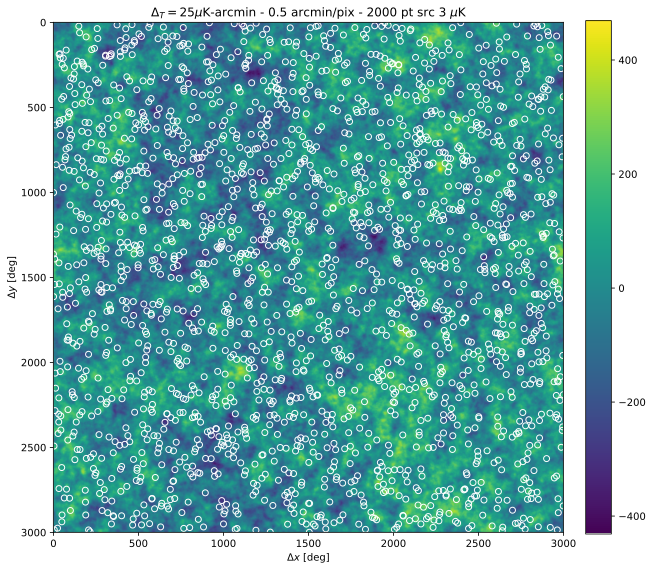

In [180]:
plt.figure(figsize=(10,10))
im = plt.imshow(tot_src_1f)#, extent=[-12.5, 12.5, 12.5, -12.5])#[2400:2700,800:1200])
plt.plot(src_x[:], src_y[:], 'wo', markerfacecolor='none', alpha=0.3)
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.xlabel(r'$\Delta x$ [deg]')
plt.ylabel(r'$\Delta y$ [deg]')
plt.title(r'$\Delta_T=25\mu$K-arcmin - 0.5 arcmin/pix - 2000 pt src 3 $\mu$K')

(6000, 6000)


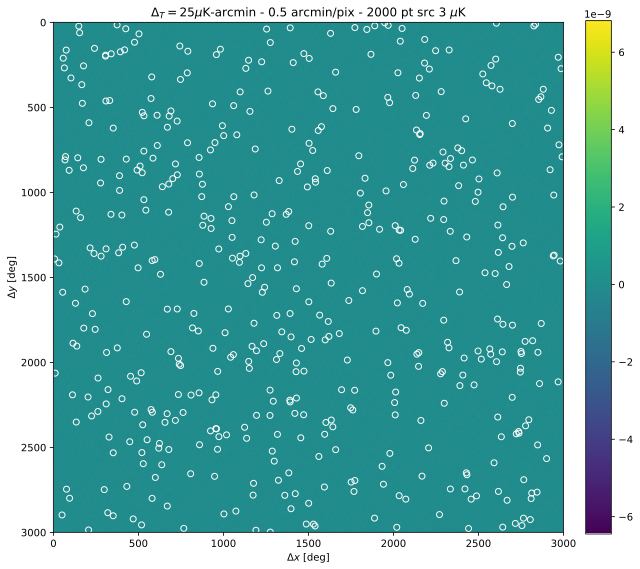

In [181]:
filtmap = MatchFilterMap(tot_src_1f, 0.5, beam=beam, lmin=None, pad=2)

plt.figure(figsize=(10,10))
im = plt.imshow(filtmap)#, extent=[-12.5, 12.5, 12.5, -12.5])#[2400:2700,800:1200])
plt.plot(src_x[:500], src_y[:500], 'wo', markerfacecolor='none', alpha=0.3)
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.xlabel(r'$\Delta x$ [deg]')
plt.ylabel(r'$\Delta y$ [deg]')
plt.title(r'$\Delta_T=25\mu$K-arcmin - 0.5 arcmin/pix - 2000 pt src 3 $\mu$K')

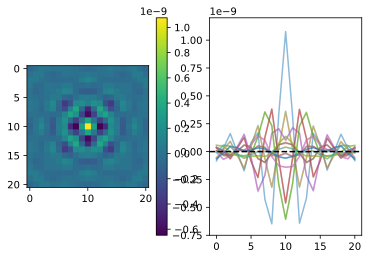

In [182]:
# Stack on filtered maps
plt.subplot(121)
plt.imshow(GoGetStack(src_x, src_y, filtmap, np.ones_like(filtmap), 10)['maps'].mean(0)); plt.colorbar()

plt.subplot(122)
for i in xrange(GoGetStack(src_x, src_y, filtmap, np.ones_like(filtmap), 10)['maps'].mean(0).shape[0]):
    plt.plot(GoGetStack(src_x, src_y, filtmap, np.ones_like(filtmap), 10)['maps'].mean(0)[i,:], alpha=0.5)
plt.axhline(ls='--', color='k')
plt.ylim([-0.75e-9,1.2e-9])
plt.savefig('/Users/fbianchini/Desktop/c.pdf')

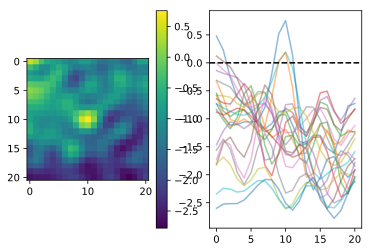

In [183]:
# Stack on unfiltered maps
plt.subplot(121)
plt.imshow(GoGetStack(src_x, src_y, tot_src_1f, np.ones_like(filtmap), 10)['maps'].mean(0)); plt.colorbar()

plt.subplot(122)
for i in xrange(GoGetStack(src_x, src_y, tot_src_1f, np.ones_like(filtmap), 10)['maps'].mean(0).shape[0]):
    plt.plot(GoGetStack(src_x, src_y, tot_src_1f, np.ones_like(filtmap), 10)['maps'].mean(0)[i,:], alpha=0.5)
plt.axhline(ls='--', color='k')


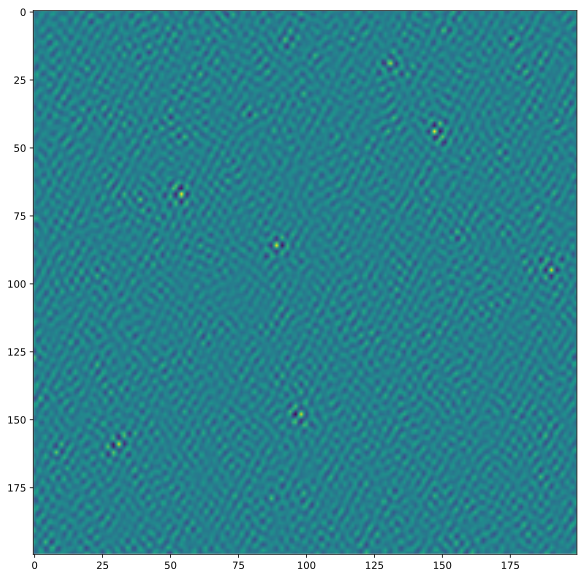

In [184]:
plt.figure(figsize=(10,10))
plt.imshow(filtmap[300:500,300:500],interpolation='None')

In [185]:
l, cl = Bin2D(np.abs(MatchFilter(tot_src_1f, 0.5, beam=beam, lmin=None, shift=True)), 0.5, lbins=np.linspace(2,10000,150))

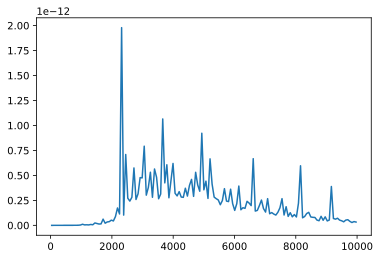

In [186]:
plt.plot(l,cl)


In [187]:
mf = MatchFilter(np.pad(tot_src_1f, ((tot_src_1f.shape[1]/2, tot_src_1f.shape[0]/2)), mode='constant', constant_values=0.), 0.5, beam=beam, lmin=None, shift=True)
lx, ly = GetLxLy(3000, 0.5)

/Users/fbianchini/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


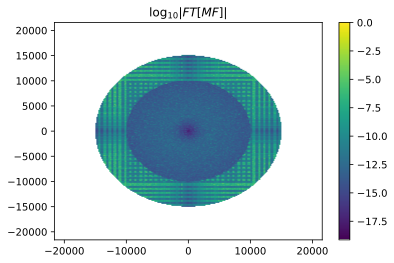

In [188]:
plt.title(r'$\log_{10}|FT[MF]|$')
plt.imshow(np.log10(np.abs(mf)), extent=[lx.min(), lx.max(), ly.min(), ly.max()], aspect='auto'); plt.colorbar()

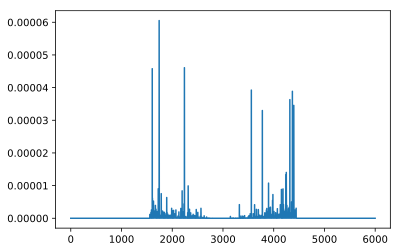

In [189]:
plt.plot(np.abs(mf)[1500,:])

In [190]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n